Fitting 3 folds for each of 16 candidates, totalling 48 fits


/home/harshit/CodeCubicle/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/harshit/CodeCubicle/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/harshit/CodeCubicle/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/harshit/CodeCubicle/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:17:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/harshit/Co

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99    142399
        True       0.99      0.99      0.99    142399

    accuracy                           0.99    284798
   macro avg       0.99      0.99      0.99    284798
weighted avg       0.99      0.99      0.99    284798

ROC AUC Score: 0.9996398276694901


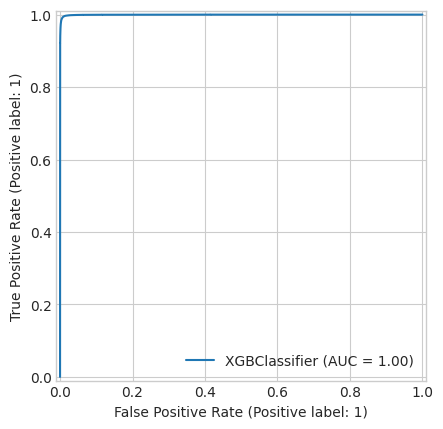

Model and scaler saved successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Load dataset
df = pd.read_csv('transaction_dataset.csv')

# Convert txn_date to datetime if not already
df['txn_date'] = pd.to_datetime(df['txn_date'])

# Time-based features
df['hour_of_day'] = df['txn_date'].dt.hour
df['day_of_week'] = df['txn_date'].dt.dayofweek

# Behavioral features: user historical averages
user_avg = df.groupby('userId').agg(
    avg_amount=('amount', 'mean'),
    avg_lat=('txn_latitude', 'mean'),
    avg_lon=('txn_longitude', 'mean')
).reset_index()

df = pd.merge(df, user_avg, on='userId', how='left')

# Feature engineering: distance from user's average location
df['distance'] = np.sqrt(
    (df['txn_latitude'] - df['avg_lat'])**2 +
    (df['txn_longitude'] - df['avg_lon'])**2
)

# Features and target
features = ['amount', 'hour_of_day', 'day_of_week', 'avg_amount', 'distance']
X = df[features]
y = df['is_anomaly']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoost classifier with GridSearch for hyperparameters
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

grid = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', verbose=1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plot ROC curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

# Save the model and scaler
joblib.dump(best_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully!")
